In [ ]:
import numpy as np
import pandas as pd
import os
for dirname, dirnames, _ in os.walk('/kaggle/input'):
    for subdirname in dirnames:
        print(os.path.join(dirname, subdirname))

/kaggle/input/brain-tumor-mri-scans
/kaggle/input/brain-tumor-mri-scans/pituitary
/kaggle/input/brain-tumor-mri-scans/healthy
/kaggle/input/brain-tumor-mri-scans/meningioma
/kaggle/input/brain-tumor-mri-scans/glioma


In [ ]:
!pip install visualkeras

import os
import warnings
warnings.filterwarnings('ignore')

import cv2
from PIL import Image

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import visualkeras
from termcolor import colored

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

import tensorflow as tf
from tensorflow.keras import models, layers, Sequential
from tensorflow.keras.layers import (
    Resizing,
    Rescaling,
    Conv2D,
    MaxPooling2D,
    BatchNormalization,
    GlobalAveragePooling2D,
    Dropout,
    Dense,
)
from keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

## Defining Constants

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS=40

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/brain-tumor-mri-scans',
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 7023 files belonging to 4 classes.


## Class Distribution

In [ ]:
class_names=dataset.class_names
class_names

['glioma', 'healthy', 'meningioma', 'pituitary']

In [ ]:
# Class Counts
class_counts = {}
for images, labels in dataset.as_numpy_iterator():
    for label in labels:
        class_label = class_names[label]
        if class_label in class_counts:
            class_counts[class_label] += 1
        else:
            class_counts[class_label] = 1

for class_name in class_names:
    count = class_counts.get(class_name, 0)
    print(f"Class {class_name}: {count} images")

Class glioma: 1621 images
Class healthy: 2000 images
Class meningioma: 1645 images
Class pituitary: 1757 images


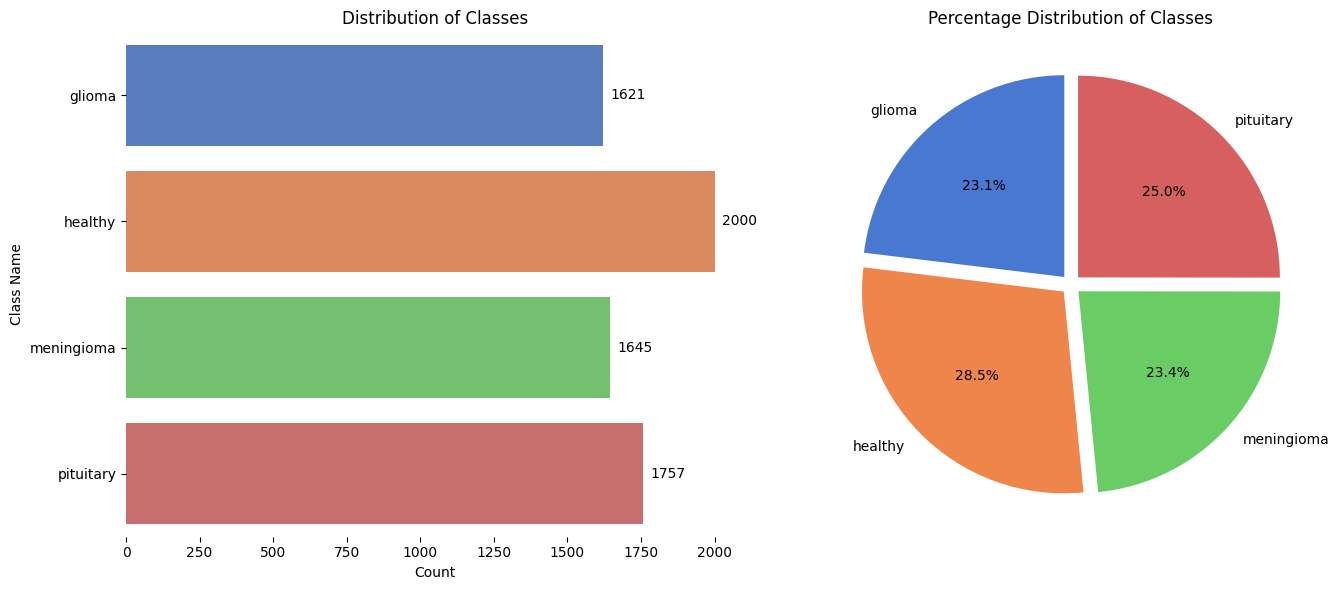

In [ ]:
# counts per class as a list
counts = [class_counts.get(class_name, 0) for class_name in class_names]

df = pd.DataFrame({
    'Class': class_names,
    'Count': counts
})

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(y='Class', x='Count', data=df, palette='muted')
plt.title('Distribution of Classes')
plt.xlabel('Count')
plt.ylabel('Class Name')
ax = plt.gca()
for p in ax.patches:
    width = p.get_width()
    ax.annotate(f'{int(width)}', (width, p.get_y() + p.get_height() / 2),
                ha='left', va='center', xytext=(5, 0), textcoords='offset points')
sns.despine(left=True, bottom=True)

plt.subplot(1, 2, 2)
df.set_index('Class')['Count'].plot.pie(autopct='%1.1f%%', colors=sns.color_palette('muted'),
                                        startangle=90, explode=[0.05]*len(class_names))
plt.title('Percentage Distribution of Classes')
plt.ylabel('')

plt.tight_layout()
plt.show()

## Pixel Intensity Statistics

In [ ]:
def get_pixel_stats(dataset, class_names):
    class_pixel_data = {name: [] for name in class_names}  # Dict to store pixel data for each class

    for images, labels in dataset.as_numpy_iterator():
        for image, label in zip(images, labels):
            class_label = class_names[label]
            class_pixel_data[class_label].append(image.flatten())

    # Calculating mean and std dev for each class
    pixel_stats = {}
    for class_name, pixels in class_pixel_data.items():
        pixels = np.concatenate(pixels)
        mean = np.mean(pixels)
        std = np.std(pixels)
        pixel_stats[class_name] = (mean, std)

    return pixel_stats

pixel_stats = get_pixel_stats(dataset, class_names)
for class_name, stats in pixel_stats.items():
    print(f"Mean: {stats[0]:.2f}, Std Dev: {stats[1]:.2f} -> {class_name} ")

Mean: 32.65, Std Dev: 39.72 -> glioma 
Mean: 60.08, Std Dev: 64.65 -> healthy 
Mean: 44.80, Std Dev: 51.03 -> meningioma 
Mean: 48.54, Std Dev: 42.48 -> pituitary 


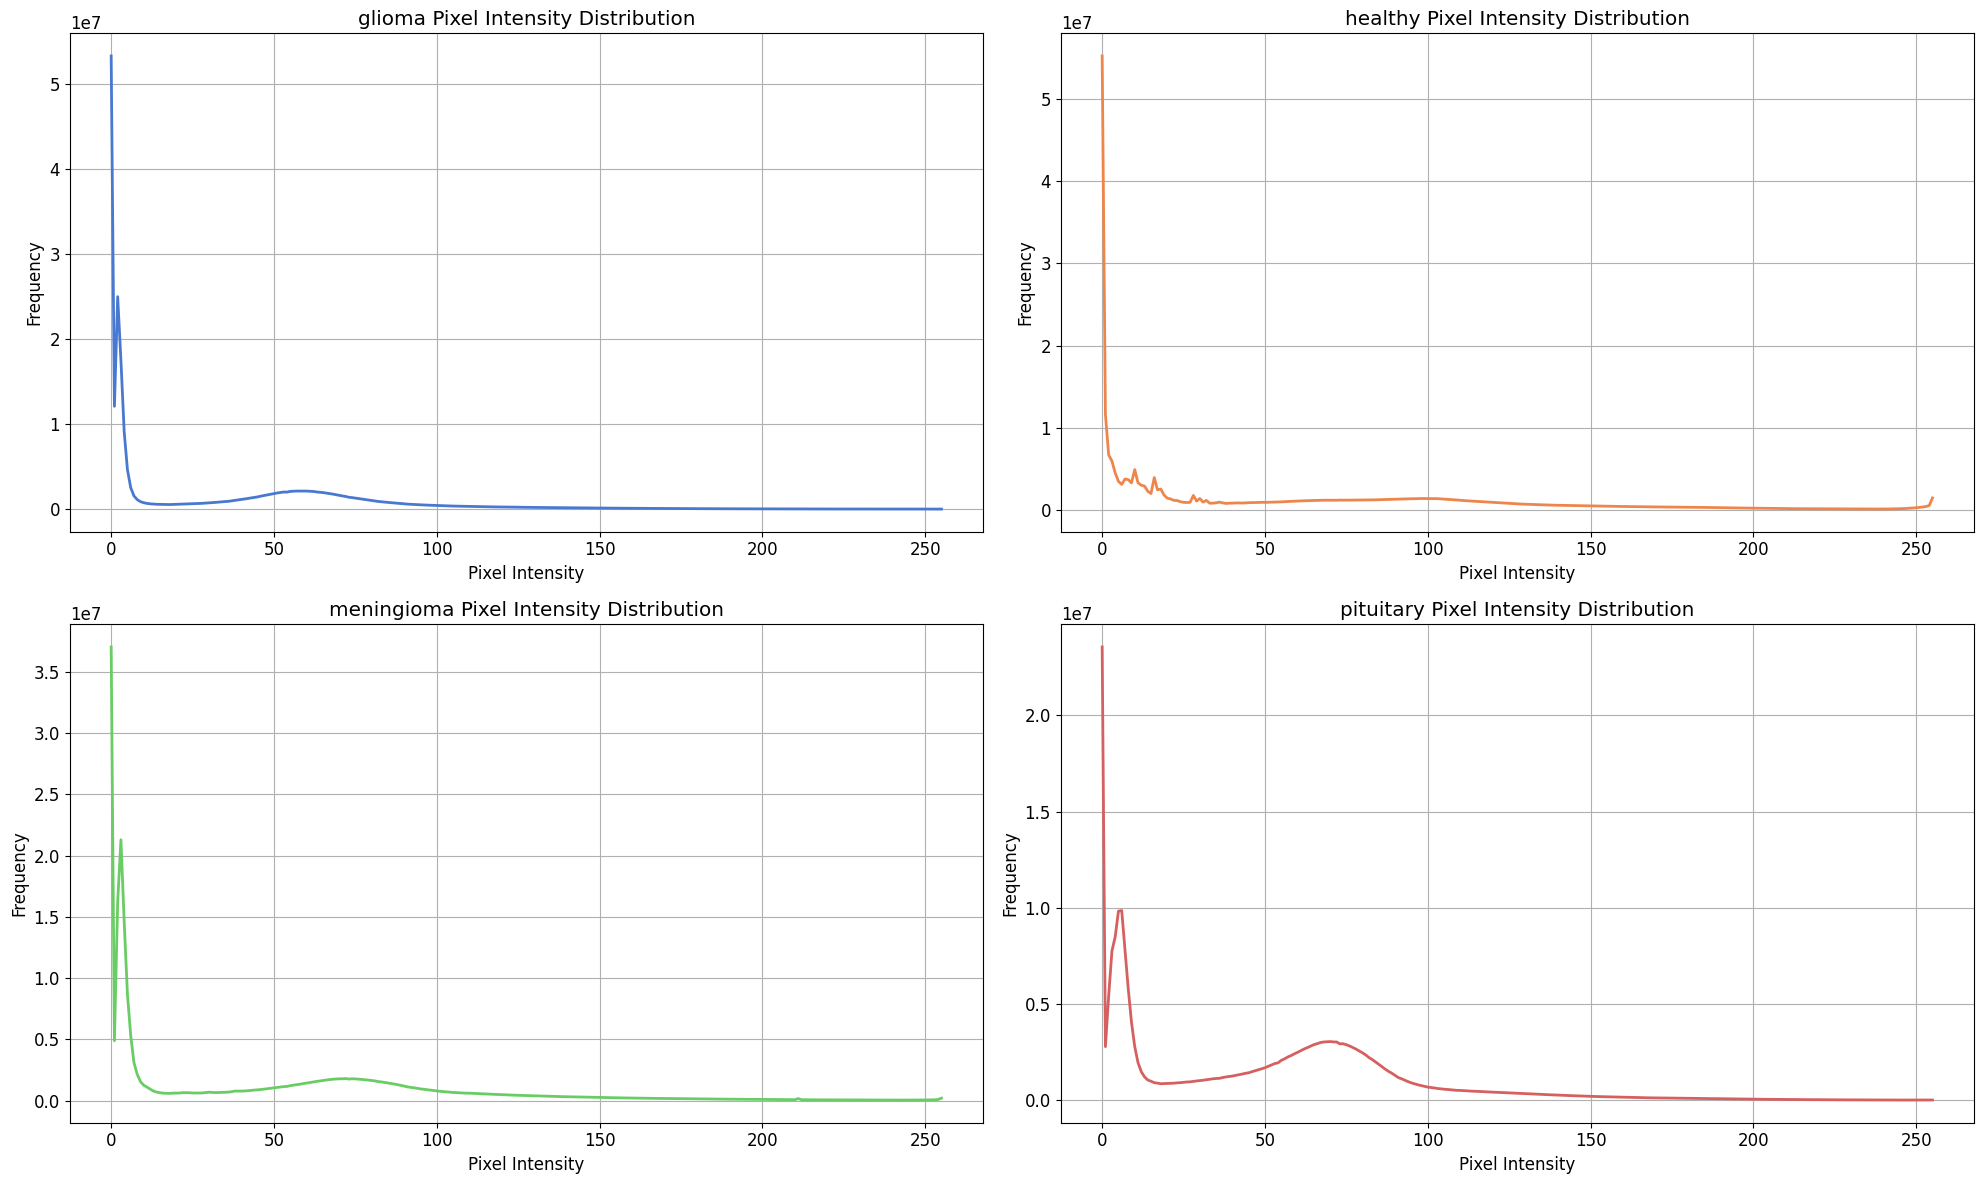

In [ ]:
def plot_pixel_histograms_efficient(dataset, class_names):
    plt.rcParams.update({'font.size': 12, 'font.family': 'sans-serif'})

    assert len(class_names) == 4, "This function is designed for 4 classes"

    colors = sns.color_palette('muted', n_colors=len(class_names))

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
    axes = axes.flatten()

    hist_data = {name: np.zeros(256) for name in class_names}
    for images, labels in dataset.as_numpy_iterator():
        for image, label in zip(images, labels):
            class_label = class_names[label]
            pixels = image.flatten()
            counts, _ = np.histogram(pixels, bins=256, range=(0, 255))
            hist_data[class_label] += counts

    for ax, (class_name, counts), color in zip(axes, hist_data.items(), colors):
        ax.plot(range(256), counts, color=color, linewidth=2)
        ax.set_title(f'{class_name} Pixel Intensity Distribution')
        ax.set_xlabel('Pixel Intensity')
        ax.set_ylabel('Frequency')
        ax.grid(True)

    plt.tight_layout()
    plt.show()

plot_pixel_histograms_efficient(dataset, class_names)

In [ ]:
# total number of batches in the dataset
len(dataset)

220

In [ ]:
# shape of the images and labels in the first batch
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 224, 224, 3)
[3 3 3 3 2 2 1 2 1 0 1 1 3 0 3 0 1 0 0 2 1 3 1 3 3 2 2 3 0 2 3 1]


In [ ]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)

(224, 224, 3)


## Visualizing Image Samples

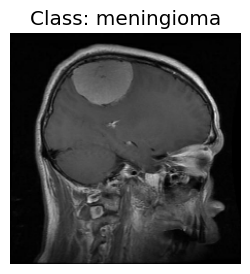

In [ ]:
# image of the first batch
for image_batch, label_batch in dataset.take(1):
    plt.figure(figsize=(3, 3))
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(f'Class: {class_names[label_batch[0]]}')
    plt.axis('off')
    plt.show()

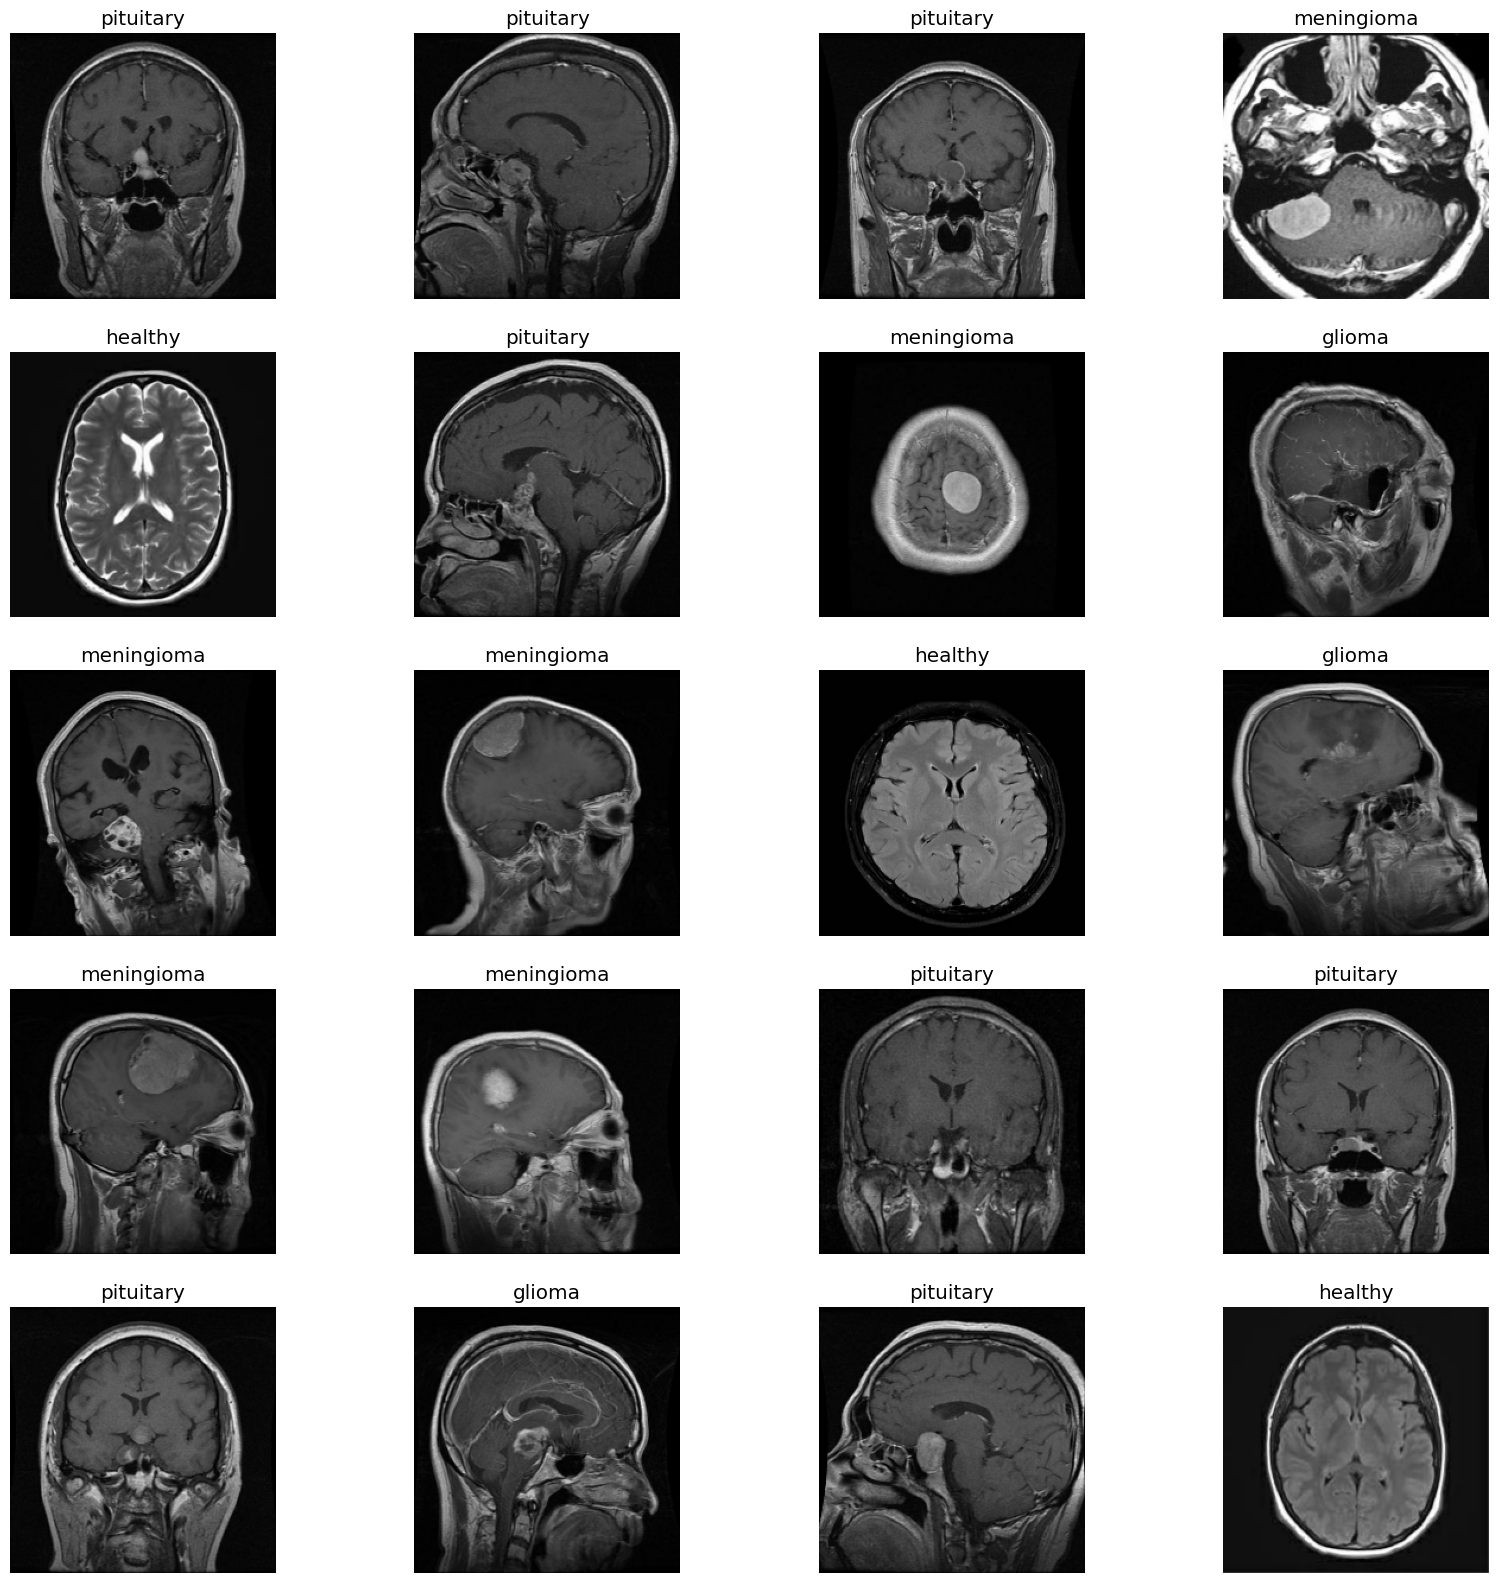

In [ ]:
# grid of images from a batch
plt.figure(figsize=(20, 20))
for image_batch, labels_batch in dataset.take(1):
    for i in range(20):
        ax = plt.subplot(5, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")
plt.show()

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + val_split + test_split) == 1, "Splits must sum to 1"

    ds_size = ds.cardinality().numpy()
    print(f"Total dataset size: {ds_size}")

    if shuffle:
        shuffle_size = max(shuffle_size, ds_size)
        ds = ds.shuffle(shuffle_size, seed=123)

    # partition sizes
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    test_size = ds_size - train_size - val_size  # will use all samples

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

print(f"Training batches: {len(train_ds)}")   # number of training batches
print(f"Validation batches: {len(val_ds)}")  # number of validation batches
print(f"Testing batches: {len(test_ds)}")    # number of testing batches


Total dataset size: 220
Training batches: 176
Validation batches: 22
Testing batches: 22


## Class Distributions Across Partitions

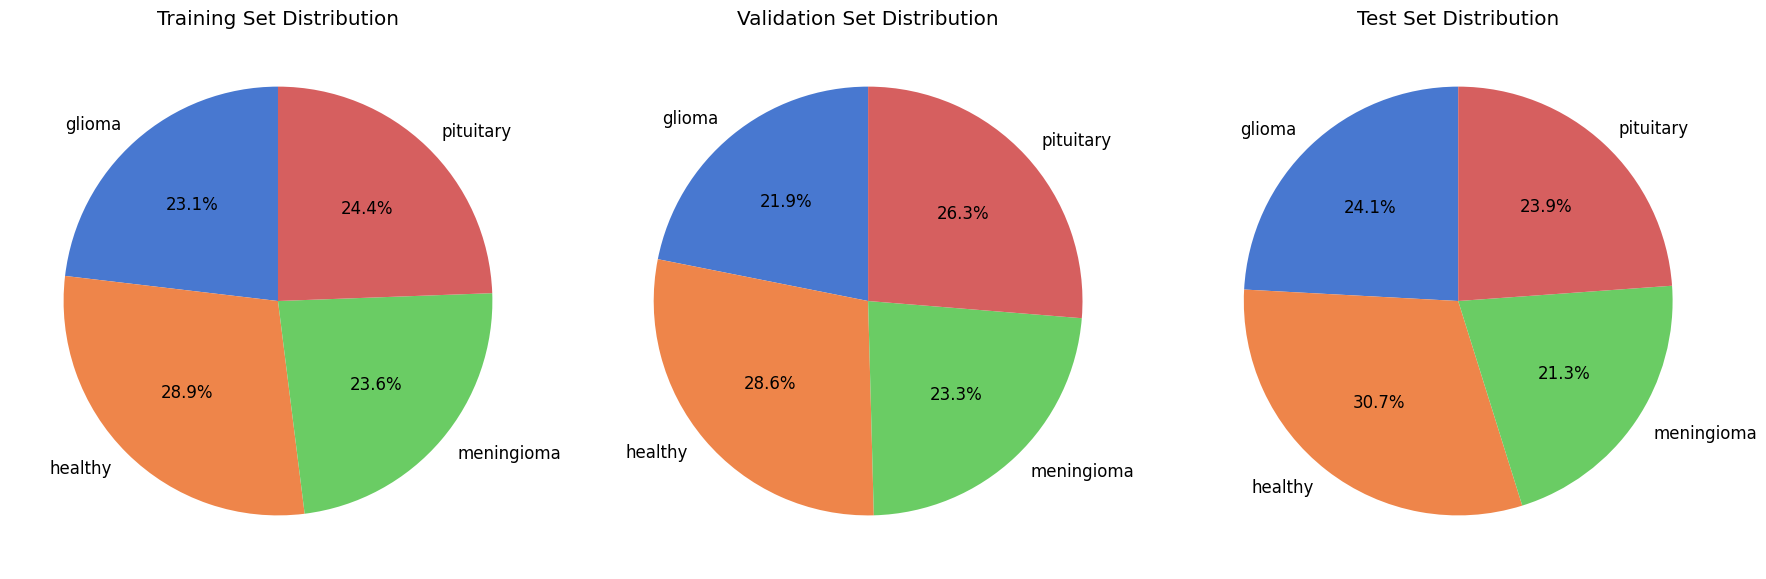

In [ ]:
def count_classes(dataset, class_names):
    class_counts = {name: 0 for name in class_names}
    for _, labels in dataset.as_numpy_iterator():
        for label in labels:
            class_counts[class_names[label]] += 1
    return class_counts

# class distributions
train_counts = count_classes(train_ds, class_names)
val_counts = count_classes(val_ds, class_names)
test_counts = count_classes(test_ds, class_names)

data = {
    'Training Set': train_counts,
    'Validation Set': val_counts,
    'Test Set': test_counts
}

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
muted_colors = sns.color_palette("muted", len(class_names))

for ax, (partition, counts) in zip(axes, data.items()):
    labels = counts.keys()
    sizes = counts.values()
    ax.pie(
        sizes,
        labels=labels,
        autopct='%1.1f%%',
        startangle=90,
        colors=muted_colors
    )
    ax.set_title(f'{partition} Distribution')

plt.tight_layout()
plt.show()

In [ ]:
# preprocessing the data
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  tf.keras.layers.Rescaling(1.0/255)
])

In [ ]:
train_ds = train_ds.map(lambda x, y: (resize_and_rescale(x), y))
val_ds = val_ds.map(lambda x, y: (resize_and_rescale(x), y))
test_ds = test_ds.map(lambda x, y: (resize_and_rescale(x), y))

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

## Model Arc

In [ ]:
n_classes =4

model = Sequential([
    Conv2D(128, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(512, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    GlobalAveragePooling2D(),
    Dropout(0.1),
    Dense(512, activation='relu'),
    Dense(n_classes, activation='softmax')
])

## Model Summary and Parameters

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 256)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 256)  │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,747,204 (6.67 MB)

 Trainable params: 1,745,412 (6.66 MB)

 Non-trainable params: 1,792 (7.00 KB)

## Listing Model Layers

In [ ]:
model_layers = [layer.name for layer in model.layers]
for index, layer_name in enumerate(model_layers):
    print(f'Layer {index}: {layer_name}')


Layer 0: conv2d
Layer 1: batch_normalization
Layer 2: max_pooling2d
Layer 3: conv2d_1
Layer 4: batch_normalization_1
Layer 5: max_pooling2d_1
Layer 6: conv2d_2
Layer 7: batch_normalization_2
Layer 8: max_pooling2d_2
Layer 9: global_average_pooling2d
Layer 10: dropout
Layer 11: dense
Layer 12: dense_1


## Visualizing the Model Diagram

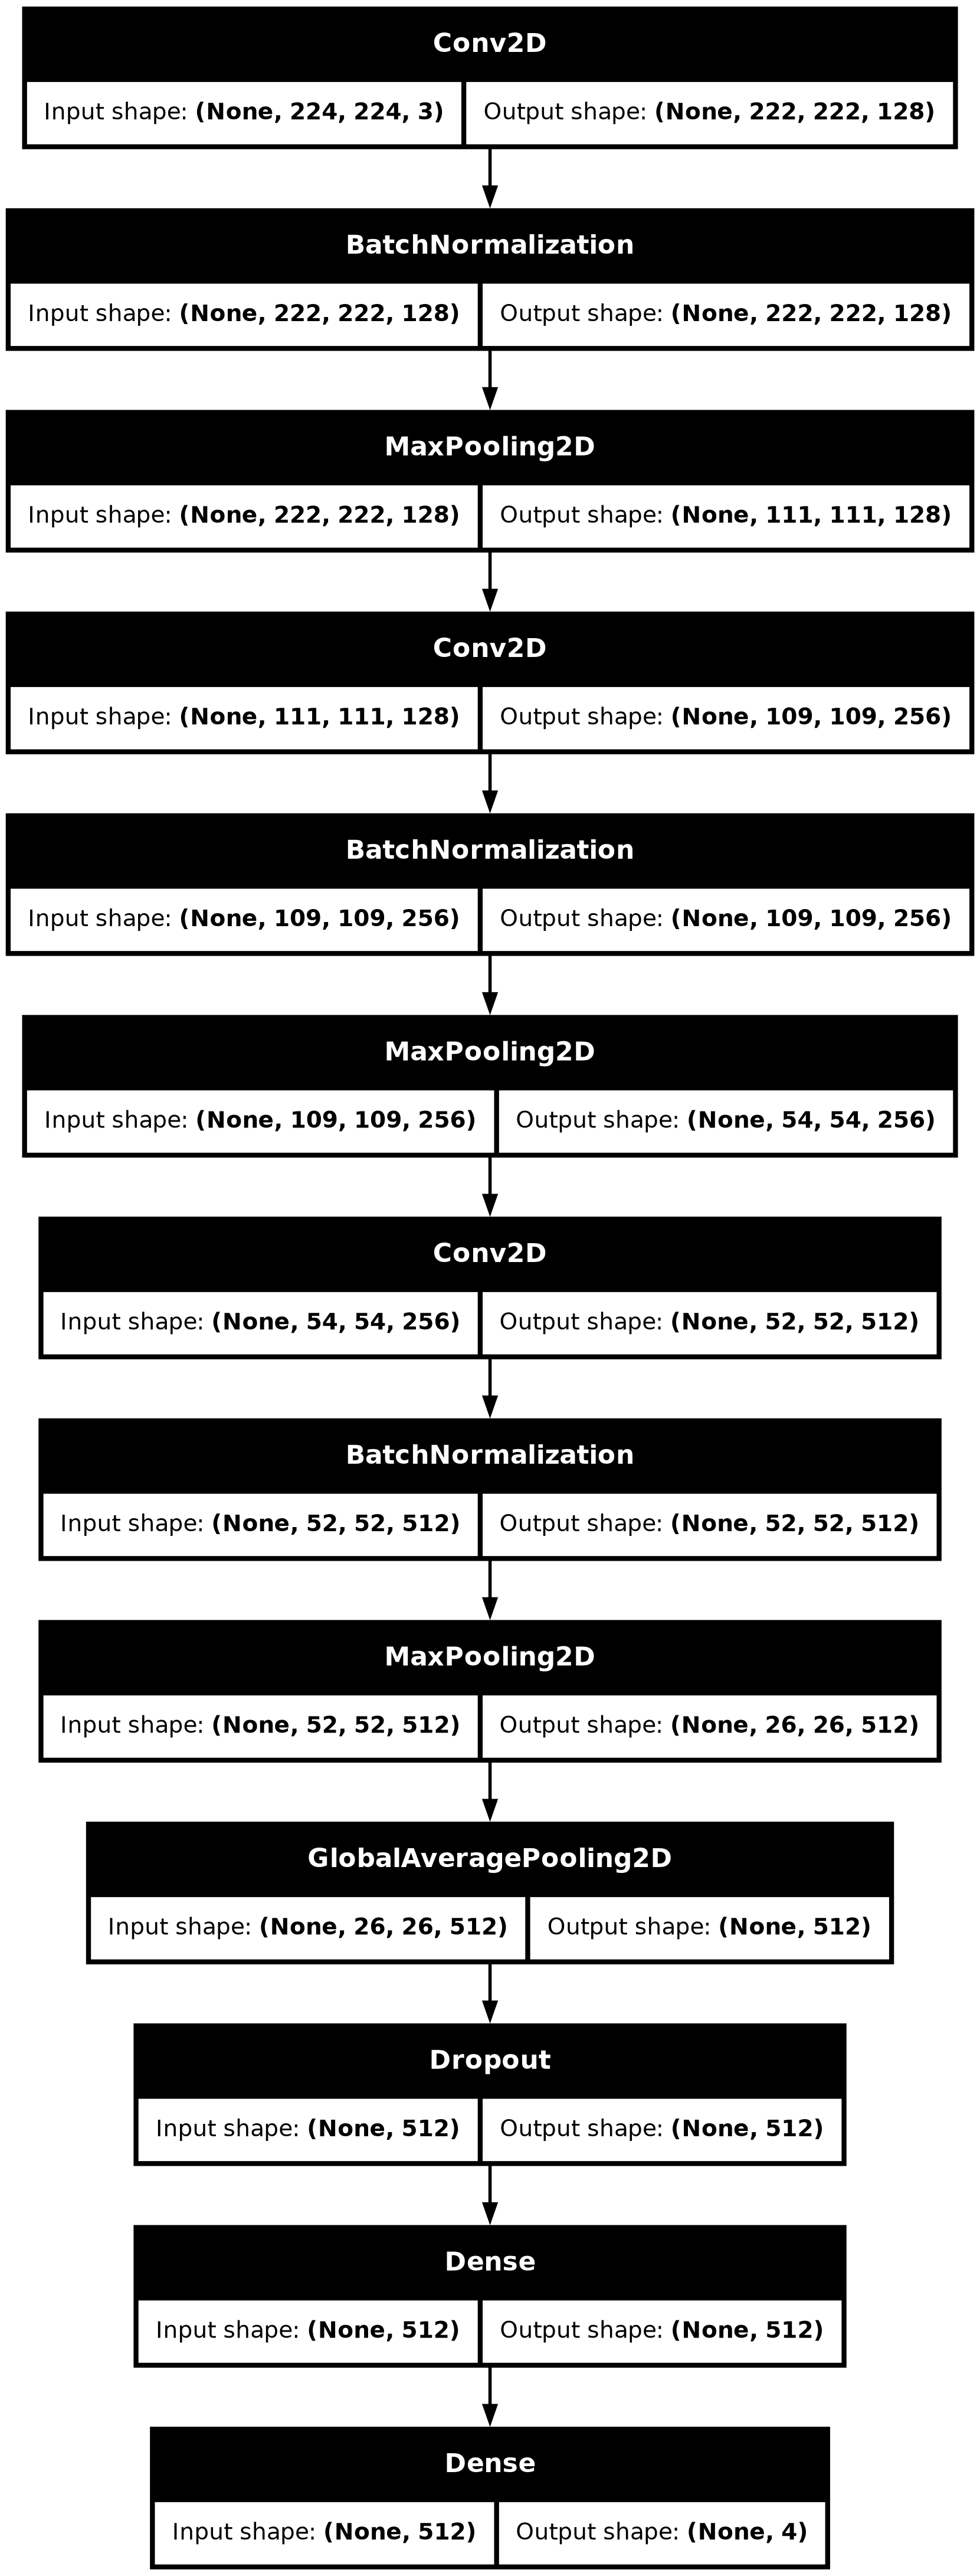

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Layered View (via visualkeras)

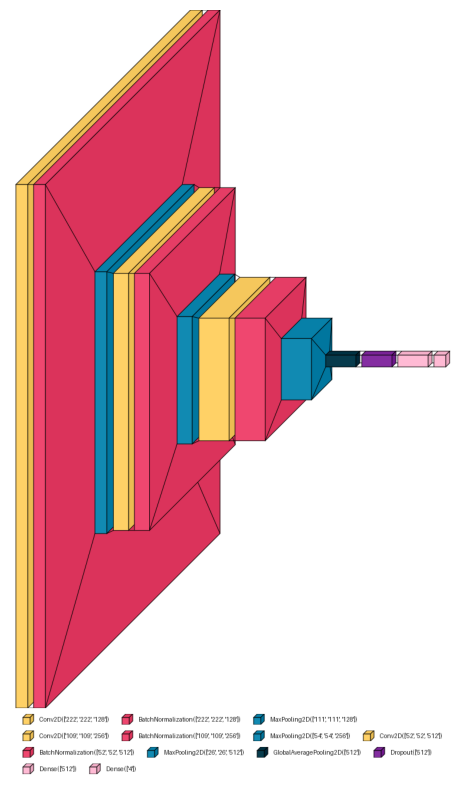

In [ ]:
img = visualkeras.layered_view(model, legend=True, show_dimension=True)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
# Compile Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

## Training Callbacks

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True,
                               verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=3,
                              verbose=1,
                              min_lr=1e-6)

callbacks = [early_stopping, reduce_lr]

## Training the Model

In [ ]:
# Train the Model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/40


I0000 00:00:1732884776.163385    1184 service.cc:145] XLA service 0x7a4e4c007d90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732884776.163434    1184 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/176 ━━━━━━━━━━━━━━━━━━━━ 1:03:03 22s/step - accuracy: 0.2188 - loss: 1.4059

I0000 00:00:1732884789.194034    1184 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads

I0000 00:00:1732884789.201505    1184 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


176/176 ━━━━━━━━━━━━━━━━━━━━ 49s 157ms/step - accuracy: 0.6543 - loss: 0.8815 - val_accuracy: 0.2798 - val_loss: 4.5429 - learning_rate: 0.0010
Epoch 2/40
176/176 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - accuracy: 0.7823 - loss: 0.5522 - val_accuracy: 0.2699 - val_loss: 4.4099 - learning_rate: 0.0010
Epoch 3/40
176/176 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - accuracy: 0.8315 - loss: 0.4265 - val_accuracy: 0.3125 - val_loss: 4.1400 - learning_rate: 0.0010
Epoch 4/40
176/176 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - accuracy: 0.8422 - loss: 0.3973 - val_accuracy: 0.4119 - val_loss: 4.1552 - learning_rate: 0.0010
Epoch 5/40
176/176 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - accuracy: 0.8482 - loss: 0.3680 - val_accuracy: 0.4162 - val_loss: 5.3322 - learning_rate: 0.0010
Epoch 6/40
176/176 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - accuracy: 0.8605 - loss: 0.3386 - val_accuracy: 0.5909 - val_loss: 1.5501 - learning_rate: 0.0010
Epoch 7/40
176/176 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - accuracy: 0.8822 - loss:

## Model Evaluation Dataset

In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
# on test

22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.9832 - loss: 0.0451
Test Loss: 0.0322
Test Accuracy: 98.86%


In [ ]:
val_loss, val_accuracy = model.evaluate(val_ds, verbose=1)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
# on validation

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9899 - loss: 0.0352
Validation Loss: 0.0510
Validation Accuracy: 98.86%


## Training and Validation Curves

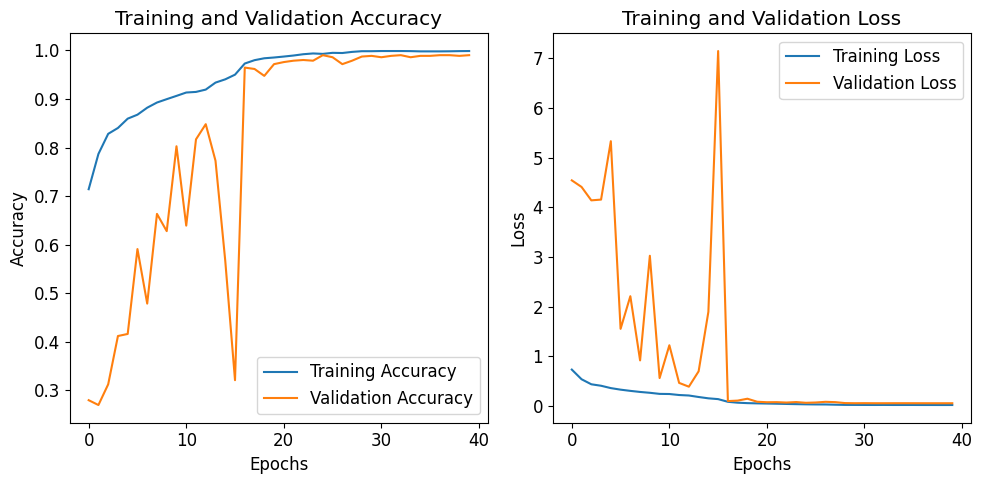

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

## Confusion Matrix and Classification Report

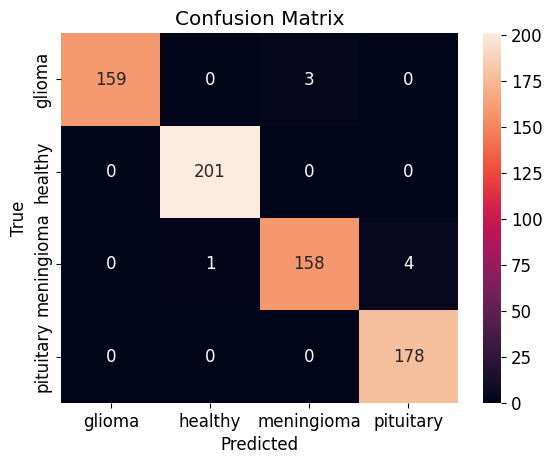

              precision    recall  f1-score   support

      glioma       1.00      0.98      0.99       162
     healthy       1.00      1.00      1.00       201
  meningioma       0.98      0.97      0.98       163
   pituitary       0.98      1.00      0.99       178

    accuracy                           0.99       704
   macro avg       0.99      0.99      0.99       704
weighted avg       0.99      0.99      0.99       704



In [ ]:
# all predictions in one step
y_true = []
y_pred = []

# collect true labels and predictions
for images, labels in test_ds:
    y_true.extend(labels.numpy())
    preds = model(images, training=False)
    y_pred.extend(tf.argmax(preds, axis=1).numpy())

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
y_pred_class_names = [class_names[pred] for pred in y_pred]
y_true_class_names = [class_names[true] for true in y_true]

print("Sample Predictions:")
num_samples = 10
for i in range(num_samples):
    if y_pred_class_names[i] == y_true_class_names[i]:
        pred_text = colored(y_pred_class_names[i], 'green')
    else:
        pred_text = colored(y_pred_class_names[i], 'red')

    print(f"Sample {i + 1}:")
    print(f"  True Label: {y_true_class_names[i]}")
    print(f"  Predicted Label: {pred_text}")
    print("-" * 30)

print("\nMisclassified Samples:")
misclassified_samples = [
    (i, true, pred) for i, (true, pred) in enumerate(zip(y_true_class_names, y_pred_class_names)) if true != pred
]

if misclassified_samples:
    print(f"Total Misclassifications: {len(misclassified_samples)}\n")
    for sample in misclassified_samples[:5]:
        index, true_label, pred_label = sample
        print(f"Sample Index: {index}")
        print(f"  True Label: {true_label}")
        print(f"  Predicted Label: {colored(pred_label, 'red')}")
        print("-" * 30)
else:
    print("No misclassifications detected!")


Sample Predictions:
Sample 1:
  True Label: glioma
  Predicted Label: glioma
------------------------------
Sample 2:
  True Label: meningioma
  Predicted Label: meningioma
------------------------------
Sample 3:
  True Label: glioma
  Predicted Label: glioma
------------------------------
Sample 4:
  True Label: pituitary
  Predicted Label: pituitary
------------------------------
Sample 5:
  True Label: pituitary
  Predicted Label: pituitary
------------------------------
Sample 6:
  True Label: healthy
  Predicted Label: healthy
------------------------------
Sample 7:
  True Label: pituitary
  Predicted Label: pituitary
------------------------------
Sample 8:
  True Label: pituitary
  Predicted Label: pituitary
------------------------------
Sample 9:
  True Label: meningioma
  Predicted Label: meningioma
------------------------------
Sample 10:
  True Label: pituitary
  Predicted Label: pituitary
------------------------------

Misclassified Samples:
Total Misclassifications: 8

In [ ]:
history.params

{'verbose': 1, 'epochs': 40, 'steps': 176}

## Receiver Operating Characteristic (ROC-AUC) Curves

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


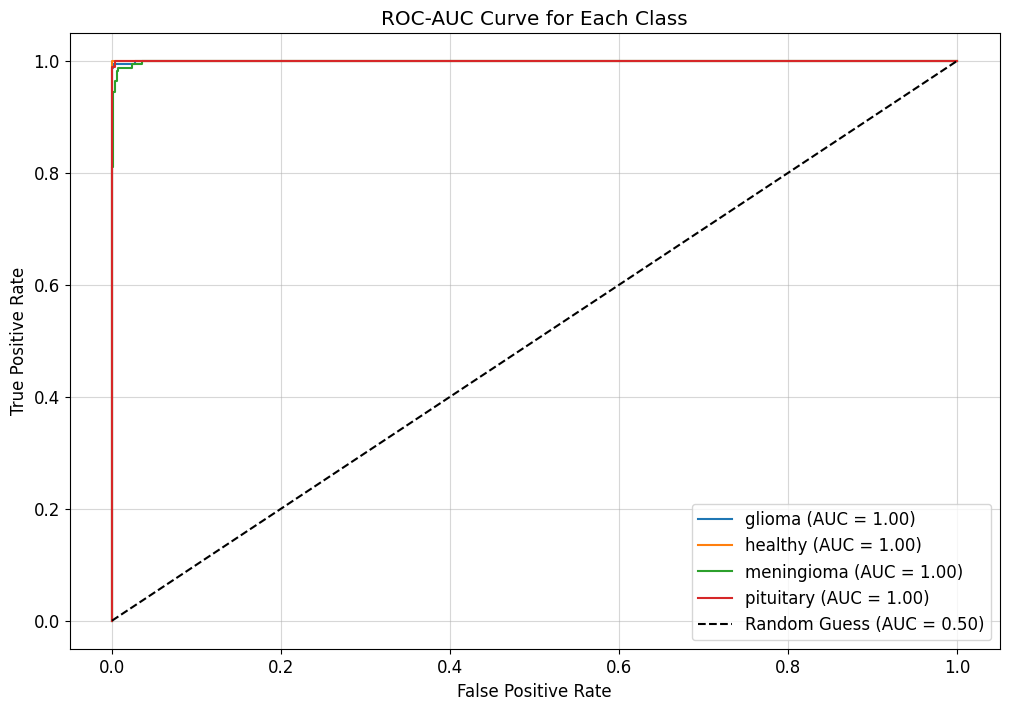

In [ ]:
# multi-class ROC calculation
y_true_binarized = label_binarize(y_true, classes=[0, 1, 2, 3])

# predicted probabilities for each class
y_pred_proba = model.predict(test_ds)

n_classes = len(class_names)

plt.figure(figsize=(12, 8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.50)')

plt.title('ROC-AUC Curve for Each Class')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(alpha=0.5)
plt.show()